This notebook steps through the process of extracting Donegal bus stops from Local Link GTFS data and labelling appropriate nodes in the road graph.

Load the GTFS data as a feed.

In [ ]:
import pandas as pd
import osmnx as ox
import config
import peartree as pt
import partridge as ptg
import networkx as nx
import testing.helpers.testing_helper as helper

In [2]:
feed = ptg.load_feed(f"{config.testing_data_path}/"
                     f"google_transit_locallink.zip")

Get Donegal routes, agency_id="LLDL"

In [ ]:
filtered_routes = feed.routes[feed.routes.agency_id == "LLDL"]
filtered_routes

Get Route IDs for the Donegal routes

In [ ]:
donegal_routes = filtered_routes.route_id.to_list()
donegal_routes

Use the route ids to find matches in stop times, the route id is included in a stop's trip id.
If a match is found add the corresponding route id as a column

In [12]:
stop_times = feed.stop_times
for route in donegal_routes:
    stop_times.loc[
        stop_times["trip_id"].str.contains(route), "route_id"] = route
stop_times


,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled,route_id
0,1.Mo-Fr.49-115-D-y11-1.1.O,25800.0,25800.0,8310B1328702,1,NaN,0,0,0.00,NaN
1,1.Mo-Fr.49-115-D-y11-1.1.O,26700.0,26700.0,831000122,2,NaN,0,0,6779.94,NaN
2,1.Mo-Fr.49-115-D-y11-1.1.O,27300.0,27300.0,8310B1320302,3,NaN,0,0,13637.85,NaN
3,1.Mo-Fr.49-115-D-y11-1.1.O,27900.0,27900.0,8310B1031301,4,NaN,0,0,20286.49,NaN
4,1.Mo-Fr.49-115-D-y11-1.1.O,28800.0,28800.0,8310B1358801,5,NaN,0,0,29956.82,NaN
...,...,...,...,...,...,...,...,...,...,...
10413,16.Sat.49-M2-y11-4.28.I,70200.0,70200.0,8540B1559201,1,NaN,0,0,0.00,NaN
10414,16.Sat.49-M2-y11-4.28.I,70500.0,70500.0,8540LL10200,2,NaN,0,0,884.54,NaN
10415,16.Sat.49-M2-y11-4.28.I,70860.0,70860.0,8540LL10195,3,NaN,0,0,2349.81,NaN
10416,16.Sat.49-M2-y11-4.28.I,71160.0,71160.0,8540LL10194,4,NaN,0,0,7986.03,NaN


Keep only route, stop and sequence columns

In [13]:
routes = stop_times[["trip_id", "route_id", "stop_id", "stop_sequence"]]
routes

,trip_id,route_id,stop_id,stop_sequence
0,1.Mo-Fr.49-115-D-y11-1.1.O,NaN,8310B1328702,1
1,1.Mo-Fr.49-115-D-y11-1.1.O,NaN,831000122,2
2,1.Mo-Fr.49-115-D-y11-1.1.O,NaN,8310B1320302,3
3,1.Mo-Fr.49-115-D-y11-1.1.O,NaN,8310B1031301,4
4,1.Mo-Fr.49-115-D-y11-1.1.O,NaN,8310B1358801,5
...,...,...,...,...
10413,16.Sat.49-M2-y11-4.28.I,NaN,8540B1559201,1
10414,16.Sat.49-M2-y11-4.28.I,NaN,8540LL10200,2
10415,16.Sat.49-M2-y11-4.28.I,NaN,8540LL10195,3
10416,16.Sat.49-M2-y11-4.28.I,NaN,8540LL10194,4


Find stops with "Derry" in their name.

In [14]:
feed.stops[feed.stops["stop_name"].str.contains("Derry")]

,stop_id,stop_name,stop_lat,stop_lon
0,7000B158241,Derry (Magee Campus Strand Road),55.004476,-7.321782
136,828000281,"Irishtown (Laois), Derrycappagh House",53.111947,-7.325835
502,848000018,Derryoughter,53.920913,-7.991871
613,852000094,"Derrycramph, Drumglen Drive",53.986386,-7.380056
656,853000095,Molloys Supermarket Derrybeg,55.078139,-8.289987
784,gen:31400:890:0:1,"Derry, Water Street",54.996069,-7.317329
875,gen:57402:8160:0:1,"Derrycassan Cottages, Simons",55.203874,-7.849413
876,gen:57402:8161:0:1,"Derrycassan, Grotto",55.210575,-7.856003


Remove the Derry stops from route times

In [15]:
ids_to_exclude = ["7000B158241", "gen:31400:890:0:1"]
routes = routes[~stop_times["stop_id"].isin(ids_to_exclude)]
len(routes)

10415

Create a dictionary of route dataframes

In [16]:
route_dict = {route: routes.loc[routes["route_id"] == route] for route in donegal_routes}
route_dict

{'49-244-y11-2':                        trip_id      route_id    stop_id  stop_sequence
 1813  1.Mo-Fr.49-244-y11-2.1.O  49-244-y11-2  853000121              2
 1814  1.Mo-Fr.49-244-y11-2.1.O  49-244-y11-2  853000059              3,
 '49-271-y11-2':                        trip_id      route_id          stop_id  stop_sequence
 2224  3.Mo-Sa.49-271-y11-2.4.I  49-271-y11-2        853000331              1
 2225  3.Mo-Sa.49-271-y11-2.4.I  49-271-y11-2  gen:57402:1:0:1              2
 2226  3.Mo-Sa.49-271-y11-2.4.I  49-271-y11-2        853000270              3
 2227  3.Mo-Sa.49-271-y11-2.4.I  49-271-y11-2        853000273              4
 2228  3.Mo-Sa.49-271-y11-2.4.I  49-271-y11-2        853000054              5
 ...                        ...           ...              ...            ...
 2337  5.Mo-Sa.49-271-y11-2.1.O  49-271-y11-2        853000053              5
 2338  5.Mo-Sa.49-271-y11-2.1.O  49-271-y11-2        853000273              6
 2339  5.Mo-Sa.49-271-y11-2.1.O  49-271-y11-2    

Find the path for each route

In [17]:
for route in donegal_routes:
    route_dict[route] = helper.get_path_of_route(route_dict[route])

Combine dictionary items into a single dataframe

In [18]:
df_list = [ v for k,v in route_dict.items()]
routes_df = pd.concat(df_list ,axis=0)
routes_df

,route_id,stop_id,stop_sequence
1813,49-244-y11-2,853000121,2
1814,49-244-y11-2,853000059,3
2224,49-271-y11-2,853000331,1
2225,49-271-y11-2,gen:57402:1:0:1,2
2226,49-271-y11-2,853000270,3
...,...,...,...
8731,49-994-y11-1,853000111,5
8732,49-994-y11-1,gen:57402:8049:0:1,6
8733,49-994-y11-1,gen:57402:8050:0:1,7
8734,49-994-y11-1,8530B141111,8


Add route indicator to stop_sequence, to differentiate stops on multiple routes

In [19]:
i = 1
for route in donegal_routes:
    routes_df.loc[
        routes_df["route_id"] == route,
        "route_order"] = f"LL{i}-" + routes_df["stop_sequence"].astype(str)
    i += 1
routes_df

,route_id,stop_id,stop_sequence,route_order
1813,49-244-y11-2,853000121,2,LL1-2
1814,49-244-y11-2,853000059,3,LL1-3
2224,49-271-y11-2,853000331,1,LL2-1
2225,49-271-y11-2,gen:57402:1:0:1,2,LL2-2
2226,49-271-y11-2,853000270,3,LL2-3
...,...,...,...,...
8731,49-994-y11-1,853000111,5,LL23-5
8732,49-994-y11-1,gen:57402:8049:0:1,6,LL23-6
8733,49-994-y11-1,gen:57402:8050:0:1,7,LL23-7
8734,49-994-y11-1,8530B141111,8,LL23-8


Drop route_id and stop_sequence

In [20]:
routes_df = routes_df.drop(["route_id", "stop_sequence"], axis=1)
routes_df

,stop_id,stop_sequence,route_order
1813,853000121,2,LL1-2
1814,853000059,3,LL1-3
2224,853000331,1,LL2-1
2225,gen:57402:1:0:1,2,LL2-2
2226,853000270,3,LL2-3
...,...,...,...
8731,853000111,5,LL23-5
8732,gen:57402:8049:0:1,6,LL23-6
8733,gen:57402:8050:0:1,7,LL23-7
8734,8530B141111,8,LL23-8


get stop co-ordinates for unique stop_ids

In [21]:
stops = routes_df["stop_id"].unique().tolist()

for stop in stops:
    stop_feed = feed.stops[feed.stops.stop_id == stop]
    routes_df.loc[
        routes_df["stop_id"] == stop,
        "lat"] = stop_feed.stop_lat.values[0]
    routes_df.loc[
        routes_df["stop_id"] == stop,
        "lng"] = stop_feed.stop_lon.values[0]
routes_df

,stop_id,stop_sequence,route_order,lat,lng
1813,853000121,2,LL1-2,55.251280,-7.261468
1814,853000059,3,LL1-3,55.189020,-7.039784
2224,853000331,1,LL2-1,54.954142,-7.728641
2225,gen:57402:1:0:1,2,LL2-2,54.961286,-7.862579
2226,853000270,3,LL2-3,54.985302,-7.889948
...,...,...,...,...,...
8731,853000111,5,LL23-5,54.761981,-8.413545
8732,gen:57402:8049:0:1,6,LL23-6,54.745630,-8.356223
8733,gen:57402:8050:0:1,7,LL23-7,54.713016,-8.310079
8734,8530B141111,8,LL23-8,54.653856,-8.285826


In [22]:
# number of stops
len(routes_df["stop_id"].unique())

184

In [23]:
len(routes_df)

209

Load graph so that locallink bus routes can be added and add node attributes for each actual route/stop

In [24]:
G = ox.load_graphml(filepath=f"{config.rp_graphml_path}/all_routes.graphml")

nx.set_node_attributes(G, "", "actual_route_order")
nx.set_node_attributes(G, False, "actual_stop")
for index, row in routes_df.iterrows():
    nearest_node = ox.get_nearest_node(G, (row["lat"], row["lng"]))
    G.nodes[nearest_node]["actual_stop"] = True

    # if node is on multiple routes add comma separation
    G.nodes[nearest_node]["actual_route_order"] = \
        row["route_order"] if \
            G.nodes[nearest_node]["actual_route_order"] == "" else \
            f"{G.nodes[nearest_node]['actual_route_order']}, {row['route_order']}"
    i += 1

In [25]:
nodes, edges = ox.graph_to_gdfs(G)
nodes

,y,x,osmid,community,rank,geometry,top_n,route_flag,community_route,community_route_order,connection,connection_order,actual_route_order,actual_stop,highway
2114650326,55.057663,-7.403884,2114650326,0,0.0002304475544637878,POINT (-7.40388 55.05766),0,0,False,32,None,-1,,False,NaN
2114650363,55.058671,-7.401458,2114650363,0,0.0005012166713618143,POINT (-7.40146 55.05867),14,0,True,36,None,-1,,False,NaN
2114650574,55.065282,-7.431412,2114650574,0,0.00039074531890811445,POINT (-7.43141 55.06528),0,0,True,24,None,-1,,False,NaN
2114650603,55.056001,-7.403478,2114650603,0,0.0002147939880001362,POINT (-7.40348 55.05600),0,0,False,-1,None,-1,,False,NaN
258442518,55.132364,-7.454354,258442518,0,0.00020807192473270327,POINT (-7.45435 55.13236),0,0,False,-1,None,-1,,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1895464217,55.022280,-8.301011,1895464217,9,0.00020824925797252749,POINT (-8.30101 55.02228),0,0,True,44,None,-1,,False,NaN
1878490428,54.931667,-8.419818,1878490428,9,0.00028288951702548035,POINT (-8.41982 54.93167),0,0,False,-1,None,-1,,False,NaN
1878490444,54.929254,-8.441124,1878490444,9,0.00028813735045901657,POINT (-8.44112 54.92925),0,0,False,-1,None,-1,LL15-4,True,NaN
1895464579,55.022001,-8.320247,1895464579,9,0.0001534778486489186,POINT (-8.32025 55.02200),0,0,False,36,None,-1,,False,NaN


Check that comma separation worked

In [26]:
nodes[nodes["actual_route_order"].str.contains(",")]

,y,x,osmid,community,rank,geometry,top_n,route_flag,community_route,community_route_order,connection,connection_order,actual_route_order,actual_stop,highway
1924390314,55.189202,-7.038989,1924390314,1,0.0002614244613985181,POINT (-7.03899 55.18920),0,0,False,88,None,-1,"LL1-3, LL11-1",True,NaN
843310079,55.251139,-7.261558,843310079,1,0.00027770146572002173,POINT (-7.26156 55.25114),0,0,False,-1,None,-1,"LL1-2, LL12-1, LL13-1",True,NaN
1922602861,54.951725,-7.724164,1922602861,10,0.00020539054971560543,POINT (-7.72416 54.95173),0,0,False,-1,None,-1,"LL4-3, LL11-6, LL19-1",True,NaN
791492626,54.953794,-7.728927,791492626,10,0.0002868546901584306,POINT (-7.72893 54.95379),0,0,False,88,None,-1,"LL2-1, LL7-1, LL11-7, LL20-6",True,NaN
529604600,54.951158,-7.428390,529604600,15,4.7061908615644145e-05,POINT (-7.42839 54.95116),0,0,False,-1,None,-1,"LL3-2, LL20-1",True,NaN
1931036767,54.934688,-7.460495,1931036767,15,0.00020382621836313153,POINT (-7.46050 54.93469),0,0,False,52,None,-1,"LL3-3, LL20-2",True,NaN
33217751,54.831812,-7.483017,33217751,15,0.0003164699029820009,POINT (-7.48302 54.83181),0,0,False,-1,None,-1,"LL3-6, LL19-2",True,NaN
1330141782,54.800150,-7.778523,1330141782,2,0.000230678263863786,POINT (-7.77852 54.80015),0,0,False,-1,None,3,"LL3-12, LL4-9",True,NaN
33217639,54.801068,-7.642184,33217639,2,0.0004084586754803834,POINT (-7.64218 54.80107),0,0,True,24,d,34,"LL3-9, LL4-6",True,NaN
794919787,55.177628,-7.793545,794919787,3,0.0005565430216973197,POINT (-7.79354 55.17763),0,0,True,18,None,-1,"LL22-1, LL22-13",True,NaN


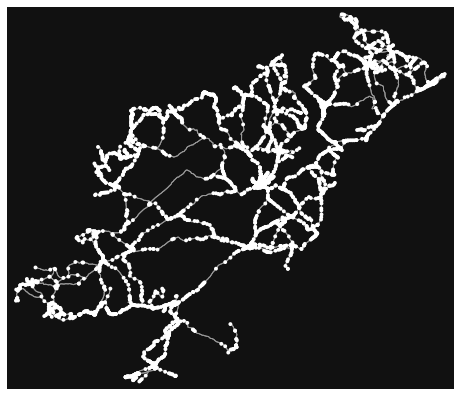

(<Figure size 576x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fa202950850>)

In [27]:
ox.plot_graph(G)

In [28]:
ox.save_graphml(G, filepath=f"{config.testing_graphml_path}/actual_routes_added.graphml")


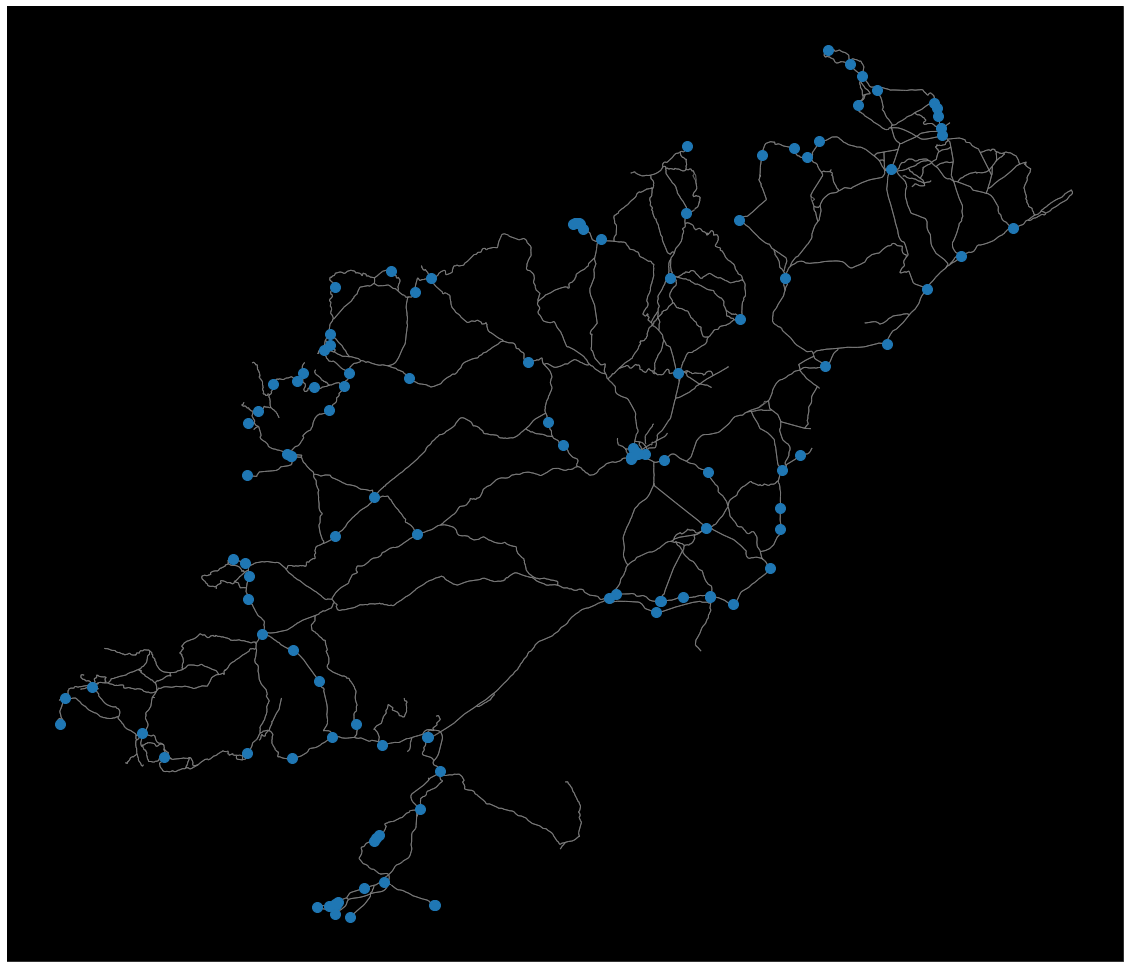

In [29]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

ll_stops = nodes[nodes["actual_stop"]]
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_facecolor("black")

plt.rc("legend", fontsize=25,
       facecolor="black")

edges.plot(
    ax=ax,
    edgecolor="grey",
    linewidth=1,
    facecolor="none",
    zorder=1,
    alpha=0.8
)

ll_stops.plot(
    ax=ax,
    marker="o",
    markersize=100,
    #column="community",
    #cmap="hsv",
    zorder=2,
    #legend=legend,
    categorical=True
)

# if legend:
#     # set text colour to white
#     leg_colour = plt.setp(ax.get_legend().get_texts(), color='w')

In [30]:
nodes = ox.graph_to_gdfs(G, edges=False)
len(nodes[nodes["actual_stop"]])

122